# Lab exercise 01, Unsupervised learning and clustering


---



1, Get and prepare data
* A, Download the data from the kaggle challenge *"Titanic: Machine Learning from Disaster"*.  https://www.kaggle.com/c/titanic You need to register to Kaggle to do so.
* B, Load the train.csv table with pandas
* C, Drop columns with the following data : names, ids, and ticket ids
* D, Encode the place or embarkation with 3 new binary columns, drop the original text column
* E, Encode the sex of the original values with 1 binary column, drop the original text column
* F, Encode in a new column whether the Cabin value was missing for a passenger or not, drop the original column
* G, Fill missing values with -1
* H, Check your dataframe, it should only contain numerical values at this point!

2, TSNE embedding
* A, Embed your dataframe without any normalization into 2 dimensions using TSNE (use the scikit-learn implementation)
* B, Plot each person a filled circle marker in the two dimensional space and colour each circle according to the continuous value of the age of the passenger
* C, Plot each person a filled circle marker in the two dimensional space and colour each circle according to the continuous value of the price of their ticket
* D, Describe the results you got, why are these variables important for TSNE?

3, TSNE with normalization.
* A, Normalize each column of your data frame to have 0 mean, and unit variance, and repeat exercise 2.
* B, For each categorical attribute, create a plot where the points are colored according to the class they belong to, also use different marker for each class on the plots.
* C, Try to guess what is the meaning of the distinct clusters? You don't need to understand every single cluster, but pick a few, and investigate them.
* D, Attempt to use K-means on your embedded 2d points to cluster them into meaningful clusters. Note, you need to somewhat correctly guess the number of clusters a priori.

4, More dimension reduction. Embed your data to 2 dimensions, and plot the data points (no need for colours etc), using
* A, UMAP (Uniform Manifold Approximation and Projection) ( you will need to install it using `pip install --user umap-learn`
* B, PCA (Principal Component Analysis), use the first two components
* C, NNMF (Non-Negative Matrix Factorization, ofter called NMF)
* D, MDS (Multidimensional scaling)   
All the tools are available in scikit-learn expect for UMAP.



---

### Hints:

* Decorate your notebook with, questions, explanation etc, make it self contained and understandable!
* Comments you code
* Write functions for repetitive tasks!
* Use the pandas package for data loading and handling
* Use matplotlib for plotting or bokeh and plotly for interactive investigation
* Use the scikit learn package for almost everything
* Remember, you need to install UMAP!







# <center> Solution </center> 

First, let us import all the things we need.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import umap
from sklearn.decomposition import PCA, NMF
from sklearn.manifold import MDS, TSNE
from sklearn.cluster import KMeans
figsize(8,8)

## 1) Preparation of the data

For excercise A) I tried to look for an in-python method for downloading the data from kaggle, but API was needed, so I used the normie solution and downloaded it manually then uploaded it to the Kooplex system.


#### B)

In [3]:
data = pd.read_csv('train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Let's see how many NaNs are there right now.

In [4]:
# By myself w the help of
# https://stackoverflow.com/questions/29530232/how-to-check-if-any-value-is-nan-in-a-pandas-dataframe
print(f"Num of nans rn: {int(sum([sum([1 for b in a if b]) for a in data.isnull().values]))} ")

Num of nans rn: 866 


There are a lot of missing values.

#### C)

In [5]:
# From documentation and help from:
# https://stackoverflow.com/questions/26886653/pandas-create-new-column-based-on-values-from-other-columns
data.drop(labels=['Name', 'PassengerId', 'Ticket'], axis = 1, inplace=True) 

#### D) & E) & F)

In [6]:
data["S"] = data.apply(lambda x: 1 if x.Embarked == 'S' else 0, axis=1)
data["Q"] = data.apply(lambda x: 1 if x.Embarked == 'Q' else 0, axis=1)
data["C"] = data.apply(lambda x: 1 if x.Embarked == 'C' else 0, axis=1)
data["Sex_if"] = data.apply(lambda x: 1 if x.Sex == 'male' else 0, axis=1)
data["Cabin_if"] = data.apply(lambda x: 0 if isinstance(x.Cabin,float) else 1, axis=1)
data.drop(labels=['Embarked', 'Sex', 'Cabin'], axis = 1, inplace=True);

Since
~~~~
>>> type(data.Cabin[0])
 float
~~~~
(which is a NaN, see above)
and
~~~~
>>> type(data.Cabin[1])
 str
~~~~
(which is a real cabin number), it is easier to search for those where there was only a float.

In [7]:
print(f"Remaining nans: {int(sum([sum([1 for b in a if b]) for a in data.isnull().values]))}")
data.head(7)

Remaining nans: 177


,Survived,Pclass,Age,SibSp,Parch,Fare,S,Q,C,Sex_if,Cabin_if
0,0,3,22.0,1,0,7.2500,1,0,0,1,0
1,1,1,38.0,1,0,71.2833,0,0,1,0,1
2,1,3,26.0,0,0,7.9250,1,0,0,0,0
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,0,1,0
5,0,3,NaN,0,0,8.4583,0,1,0,1,0
6,0,1,54.0,0,0,51.8625,1,0,0,1,1


#### G)

In [8]:
# Easiest solution:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html
data.fillna(-1, inplace=True)

#### H)

In [9]:
print(f"Remaining nans: {int(sum([sum([1 for b in a if b]) for a in data.isnull().values]))}")
data.head(7)

Remaining nans: 0


,Survived,Pclass,Age,SibSp,Parch,Fare,S,Q,C,Sex_if,Cabin_if
0,0,3,22.0,1,0,7.2500,1,0,0,1,0
1,1,1,38.0,1,0,71.2833,0,0,1,0,1
2,1,3,26.0,0,0,7.9250,1,0,0,0,0
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,0,1,0
5,0,3,-1.0,0,0,8.4583,0,1,0,1,0
6,0,1,54.0,0,0,51.8625,1,0,0,1,1


As one can see, the age of person with id 8 has been changed to -1. Weird but okay.

## 2) TSNE

#### A)

In [10]:
# From the documentation
data_emb = TSNE().fit_transform(data) # no other parameters were specified

Checking wheter the dimensions are correct.

In [11]:
data.shape, data_emb.shape

((891, 11), (891, 2))

Shapes match, no one is lost (at least, not now).

#### B)

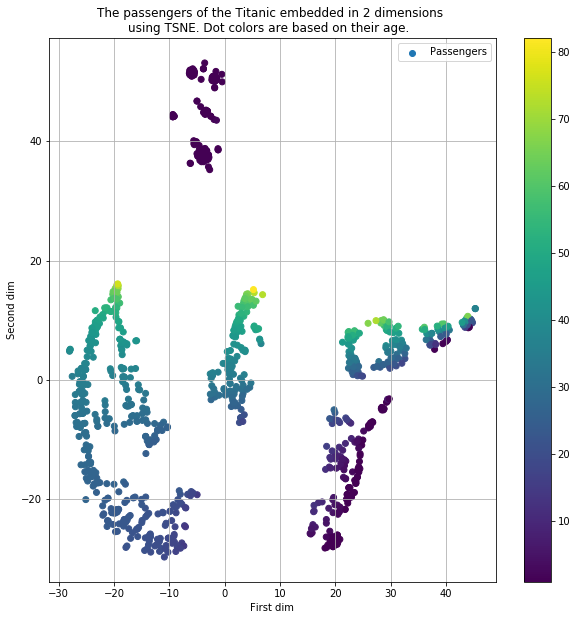

In [12]:
# Cheated again: https://stackoverflow.com/questions/14827650/pyplot-scatter-plot-marker-size
# (if it is cheating)

figsize(10,10)
plt.title("The passengers of the Titanic embedded in 2 dimensions \n" 
          +"using TSNE. Dot colors are based on their age.  ")
xlabel("First dim")
ylabel("Second dim")
plt.scatter(data_emb[:, 0], data_emb[:, 1], c=data.Age+2, 
            label = 'Passengers') # so that every poitn is visible
legend(loc = "best")
colorbar()
grid()

#### C)

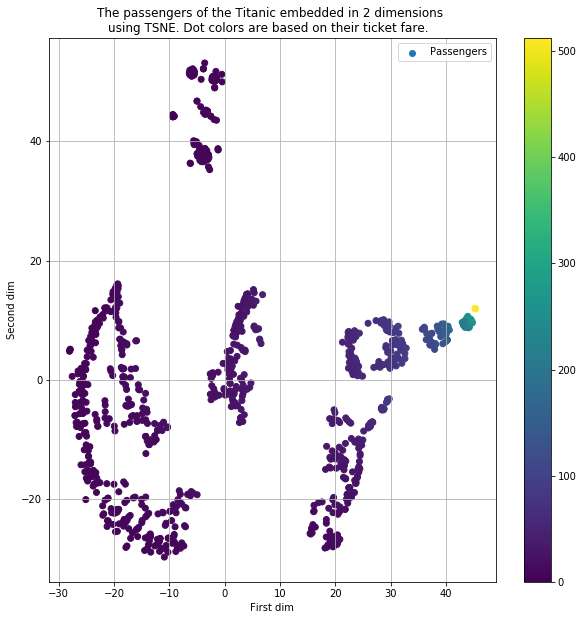

In [13]:
figsize(10,10)
plt.title("The passengers of the Titanic embedded in 2 dimensions \n" 
          +"using TSNE. Dot colors are based on their ticket fare.  ")
xlabel("First dim")
ylabel("Second dim")
plt.scatter(data_emb[:, 0], data_emb[:, 1], c=data.Fare,
            label = 'Passengers') # so that every poitn is visible
legend(loc = "best")
colorbar()
grid()

#### D)

It does seem like these two measures are important because both are continous variables and vary over much larger ranges than for example the *Pclass* (1-3) or the *Sex* (0-1). It can be stated that the dimensions we got after the dimension reduction are mainly dominated by these two measures because the variances are not the same.

## 3) TSNE w norm

#### A)

First, normalizing the data.

In [14]:
# https://stackoverflow.com/questions/12525722/normalize-data-in-pandas
# But could've figured it out tbh.
data_norm = (data - data.mean()) / data.std()

Quick check

In [17]:
data_norm.Parch.std()

0.999999999999995

Then fit again

In [16]:


data_en = TSNE().fit_transform(data_norm) 

In [17]:
data.shape, data_en.shape

((891, 11), (891, 2))

Still match, allright.

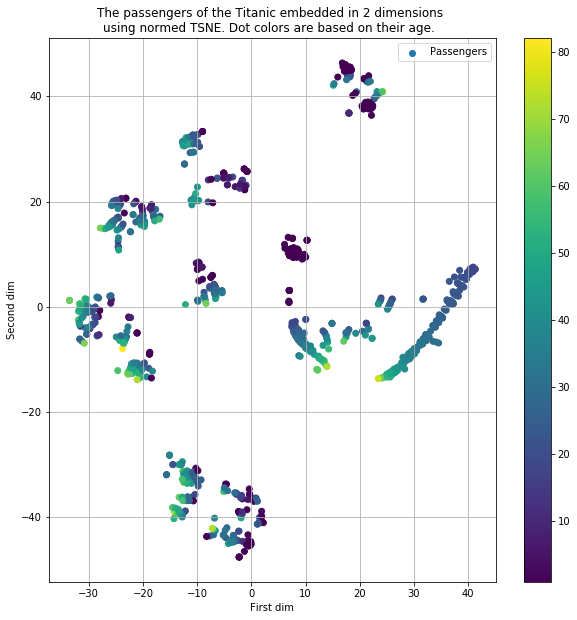

In [18]:
figsize(10,10)
plt.title("The passengers of the Titanic embedded in 2 dimensions \n" 
          +"using normed TSNE. Dot colors are based on their age.  ")
xlabel("First dim")
ylabel("Second dim")
plt.scatter(data_en[:, 0], data_en[:, 1], c=data.Age+2,
            label = 'Passengers') # so that every poitn is visible
legend(loc = "best")
colorbar()
grid()

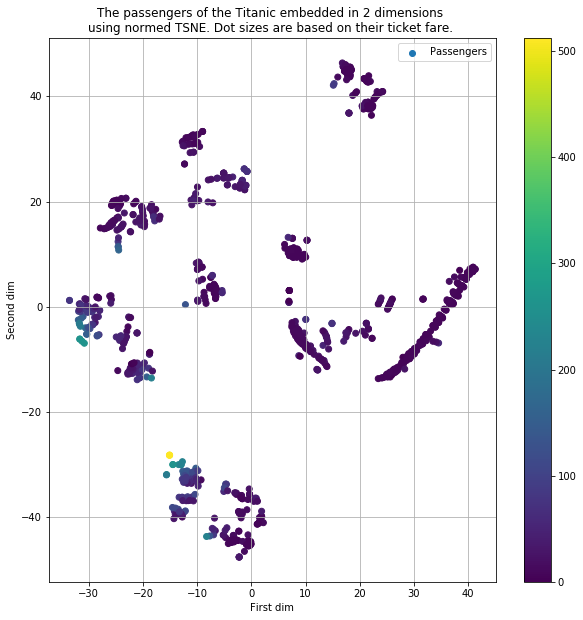

In [19]:
figsize(10,10)
plt.title("The passengers of the Titanic embedded in 2 dimensions \n" 
          +"using normed TSNE. Dot sizes are based on their ticket fare. ")
xlabel("First dim")
ylabel("Second dim")
plt.scatter(data_en[:, 0], data_en[:, 1], c=data.Fare,
            label = 'Passengers') # so that every poitn is visible
legend(loc = "best")
colorbar()
grid()

As one can see, by now, our assumpiton must have been correct, since the clear tendency has vanished by using normalized data.

#### B) & C)

Since now I only need to create plots for those which have exact classes, I am going to omit Age and Fare.

In [20]:
data.keys()

Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'S', 'Q', 'C',
       'Sex_if', 'Cabin_if'],
      dtype='object')

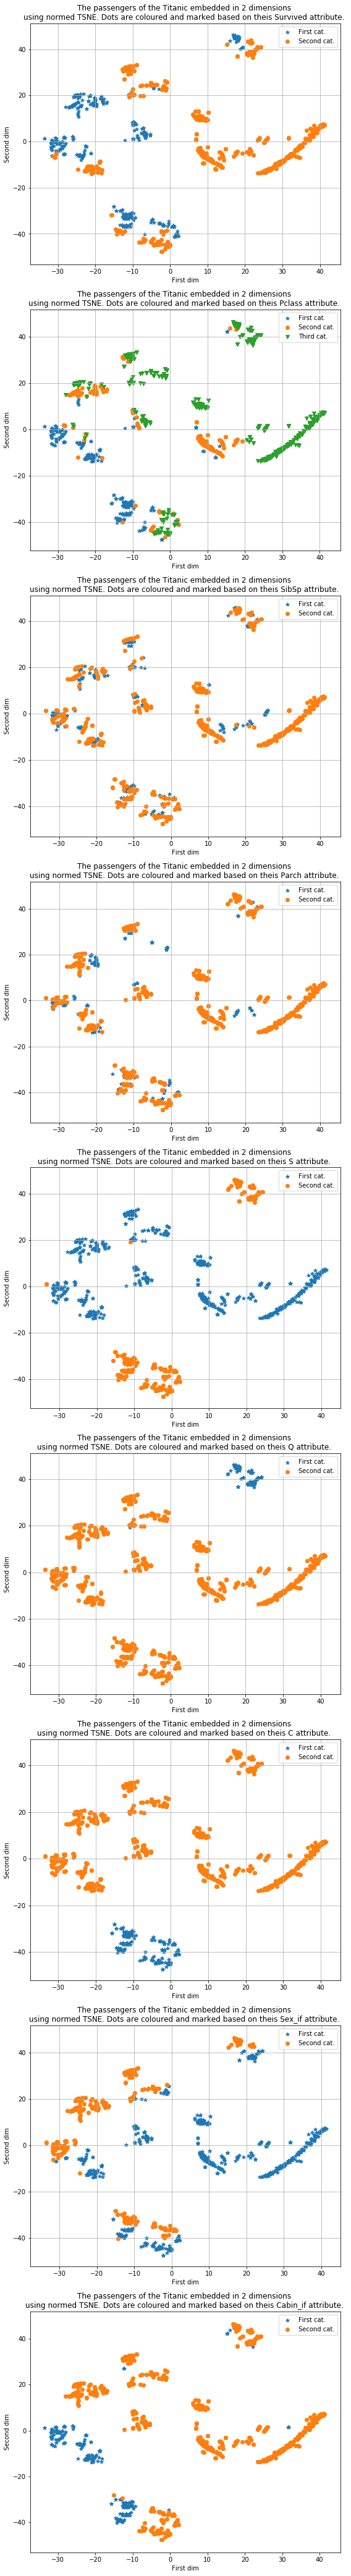

In [21]:
r = list(data.keys())
figsize(8, 70)
cnt = 1
for k in range(len(r)):

    data1 = array([data_en[i]  for i in range(data.shape[0]) if data[r[k]][i] == 1])
    data2 = array([data_en[i]  for i in range(data.shape[0]) if data[r[k]][i] == 0 ])
    grid(True)
    if r[k] == 'Pclass':
        data2 = array([data_en[i]  for i in range(data.shape[0]) if data[r[k]][i] == 2 ])
        data3 = array([data_en[i]  for i in range(data.shape[0]) if data[r[k]][i] == 3 ])
        plt.subplot(len(r), 1, cnt+1)
        cnt += 1
        plt.scatter(data1[:,0],data1[:,1], marker = '*', label = "First cat.")
        plt.scatter(data2[:,0],data2[:,1], marker =  "o", label = "Second cat.")
        plt.scatter(data3[:,0],data3[:,1], marker =  "v", label = "Third cat.")
        legend(loc= 'best')
        plt.title(f"The passengers of the Titanic embedded in 2 dimensions \n" 
                  +f"using normed TSNE. Dots are coloured and marked based on theis {r[k]} attribute. ")
        xlabel("First dim")
        ylabel("Second dim")
        plt.tight_layout()
    elif r[k] != 'Age' and r[k]!= 'Fare':
        plt.subplot(len(r), 1, cnt+1)
        cnt += 1
        plt.scatter(data1[:,0],data1[:,1], marker = '*', label = "First cat.")
        plt.scatter(data2[:,0],data2[:,1], marker =  "o", label = "Second cat.")
        legend(loc= 'best')
        plt.title(f"The passengers of the Titanic embedded in 2 dimensions \n" 
                  +f"using normed TSNE. Dots are coloured and marked based on theis {r[k]} attribute. ")
        xlabel("First dim")
        ylabel("Second dim")
        plt.tight_layout()


Clear separation of the classes can be seen when they are grouped based on their place of embarkation (S, C, Q attributes). Surely, since these attributes are correlated, no one cant depart at two distinct ports. Maybe based on ther Cabin_if attribute also. On the other pictures I cannot see meaningful separation.

#### D)

Based on visual presupposition, the optimal number of clusters is 8. Maybe, a dendrogram would be better two show some normalized overall distance from each cluster center.

In [46]:
n = 8
data_km = KMeans(n).fit(data_en)
len(data_km.labels_)

891

Putting them into a new Dataframe for easier handling.

In [47]:
data_k = pd.DataFrame(data_en, columns=['X', 'Y'])

In [48]:
data_k['cluster'] = data_km.labels_ 

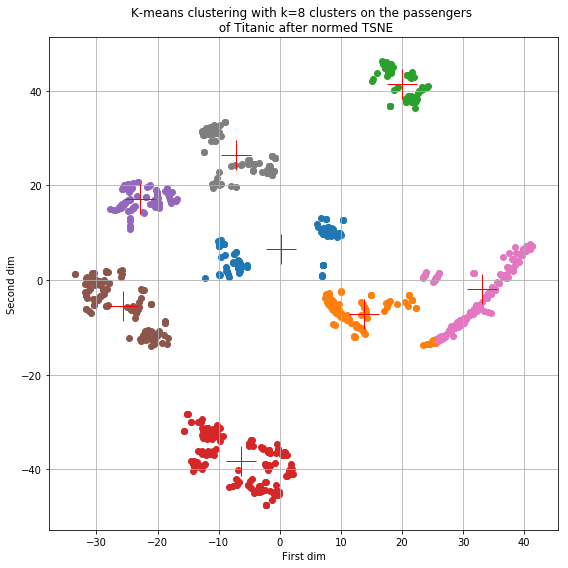

In [49]:
figsize(8,8)
for i in range(n):
    data_sub = array([data_en[j] for j in range(data_en.shape[0]) if data_k['cluster'][j] == i])
    plt.scatter(data_sub[:, 0],data_sub[:,1])
plt.plot(data_km.cluster_centers_[:, 0], data_km.cluster_centers_[:, 1], 'r+', ms = 30)
title(f'K-means clustering with k={n} clusters on the passengers \n of Titanic after normed TSNE')
grid()
xlabel("First dim")
ylabel("Second dim")
plt.tight_layout()

Two clusters (at the bottom) may overlap, but more-or-less the clusters are separate from each other. 

## 4) Other methods

#### A) UMAP

/home/ahmitr/.local/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


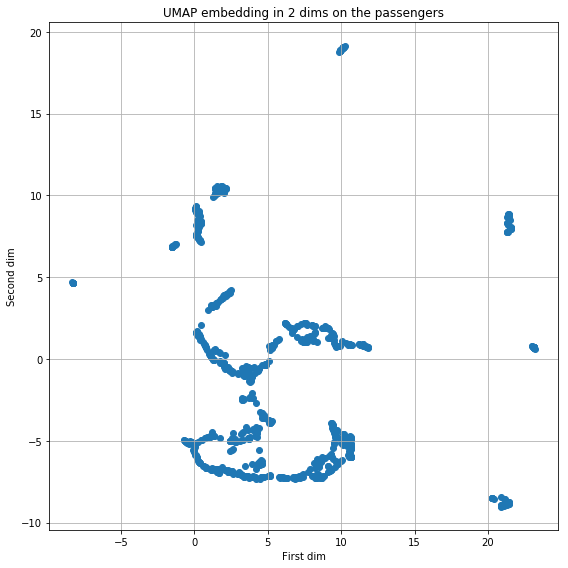

In [30]:
# From documentation: https://pypi.org/project/umap-learn/
embedding = umap.UMAP().fit_transform(data)

scatter(embedding[:, 0],embedding[:, 1])
title(f'UMAP embedding in 2 dims on the passengers')
grid()
xlabel("First dim")
ylabel("Second dim")
plt.tight_layout()

Let's check with normalization.

/home/ahmitr/.local/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 3 separate connected components using meta-embedding (experimental)
  n_components


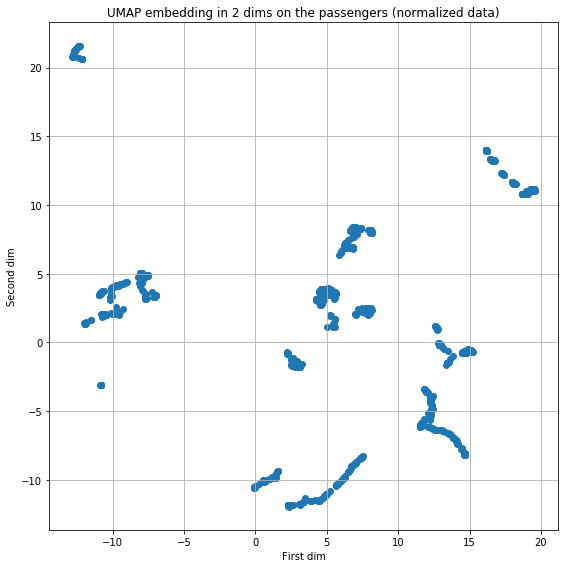

In [31]:
embedding = umap.UMAP().fit_transform(data_norm)

scatter(embedding[:, 0],embedding[:, 1])
title(f'UMAP embedding in 2 dims on the passengers (normalized data)')
grid()
xlabel("First dim")
ylabel("Second dim")
plt.tight_layout()

Indeed, normalization plays a crucial role here, too. 

#### B) PCA

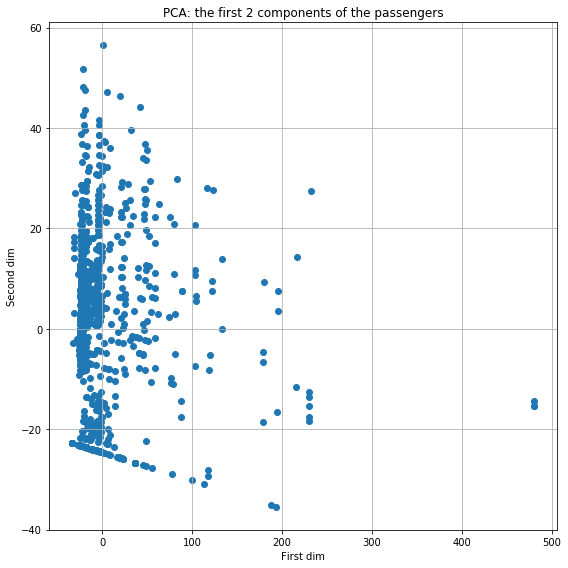

In [32]:
p = PCA(2).fit(data)
d = p.transform(data)

scatter(d[:, 0], d[:, 1])
title(f'PCA: the first 2 components of the passengers')
grid()
xlabel("First dim")
ylabel("Second dim")
plt.tight_layout()

Maybe norm?

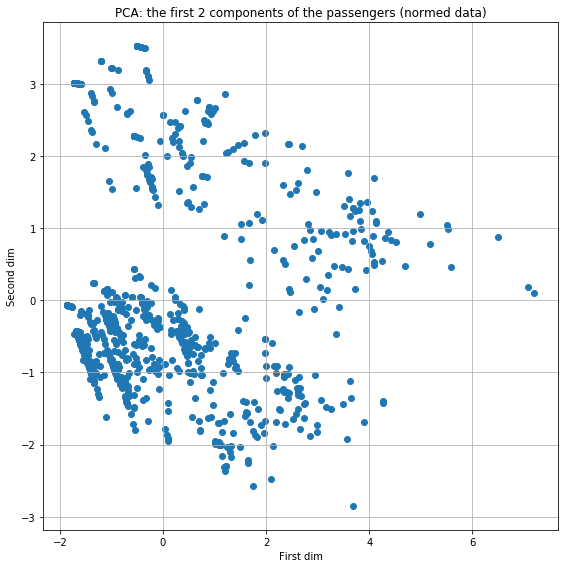

In [33]:
p = PCA(2).fit(data_norm)
d = p.transform(data_norm)

scatter(d[:, 0], d[:, 1])
title(f'PCA: the first 2 components of the passengers (normed data)')
grid()
xlabel("First dim")
ylabel("Second dim")
plt.tight_layout()

Only two big clusters can be seen. Normalization must have stretched out one dimension that was compressed at the beginning.

#### C) NMF

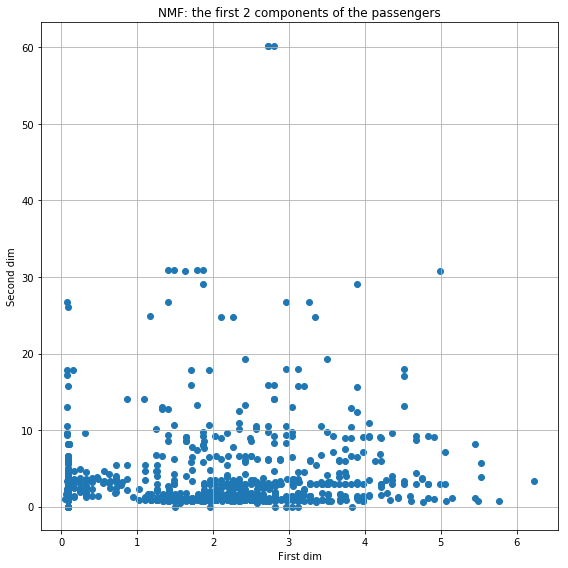

In [34]:
# With the help of the documentation
model = NMF(n_components=2, init='random', random_state=0)
W = model.fit_transform(abs(data))
H = model.components_

scatter(W[:, 0], W[:, 1])
title(f'NMF: the first 2 components of the passengers')
grid()
xlabel("First dim")
ylabel("Second dim")
plt.tight_layout()

There is a clear outlier. Let us do the norming.

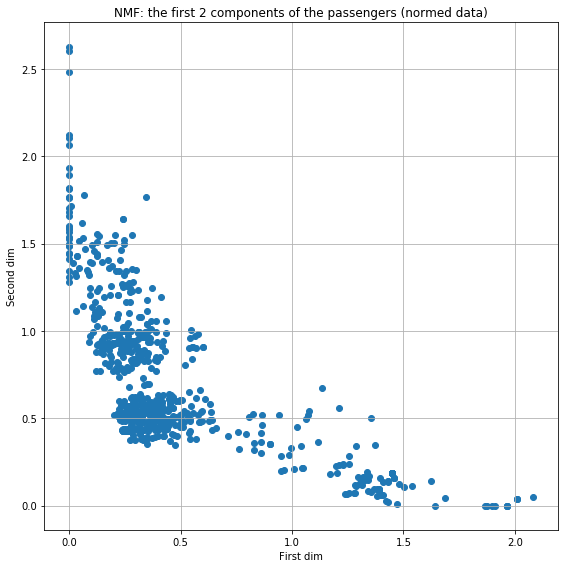

In [35]:
model = NMF(n_components=2, init='random', random_state=0)
W = model.fit_transform(abs(data_norm))
H = model.components_

scatter(W[:, 0], W[:, 1])
title(f'NMF: the first 2 components of the passengers (normed data)')
grid()
xlabel("First dim")
ylabel("Second dim")
plt.tight_layout()

Oops. This makes no sense. 

Obviously, since I normed the data, then took the abs of that, because this modelling needs only non-negative data.

#### d)  ~~MDF~~ MDS

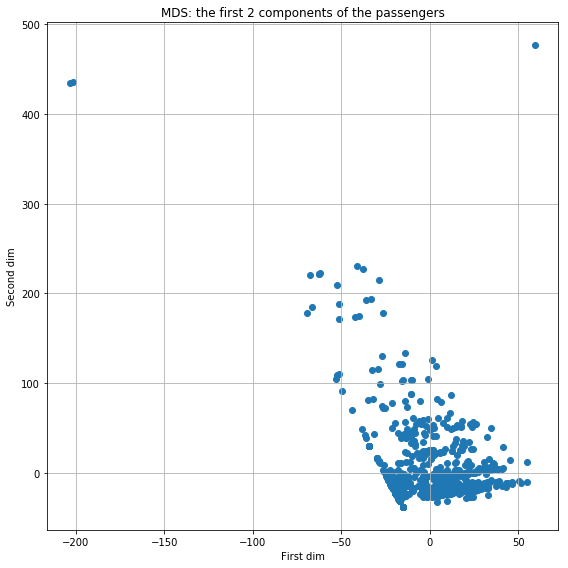

In [36]:
m = MDS()
w = m.fit_transform(data)

scatter(w[:, 0], w[:, 1])
title(f'MDS: the first 2 components of the passengers')
grid()
xlabel("First dim")
ylabel("Second dim")
plt.tight_layout()

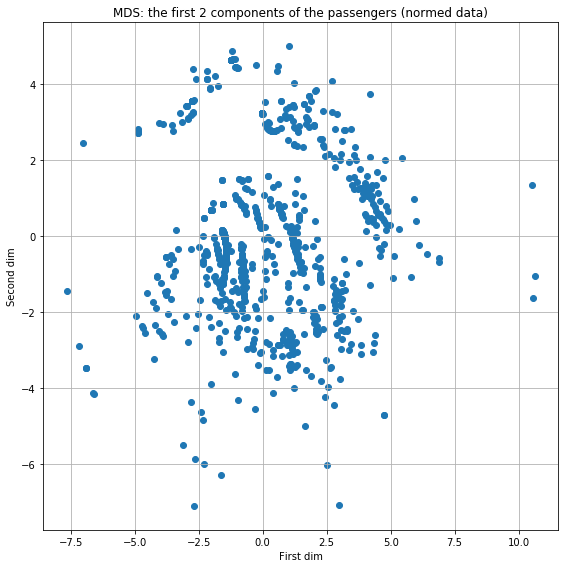

In [37]:
m = MDS()
w = m.fit_transform(data_norm)

scatter(w[:, 0], w[:, 1])
title(f'MDS: the first 2 components of the passengers (normed data)')
grid()
xlabel("First dim")
ylabel("Second dim")
plt.tight_layout()

It seems like, there is an outer layer of points (outside of the core).